<h1>Assesment Question:</h1>
<p>1- How are blood donations in Malaysia / states trending?</p>
<p>2- How well is Malaysia retaining blood donors? (meaning, are people with a history of blood donation coming back to donate regularly)</p>

And after creating data visualisation for answering this questions, we will need to use Telegram bot API to post a message in a group daily

Question in mind:
1. What visualisation that are useful for daily updates? Or is it sufficient enough to use only visualisation
2. What time they update the data, to find the optimal time to post the data to the Telgram group (Weekend & Public Holiday has no new update)
3. What is Blood Expiry. https://www.utoledo.edu/policies/utmc/bloodbank/pdfs/3364-108-202.pdf 21-49 days

In [69]:
import os
import requests

import pandas as pd 
import numpy as np 
import pyarrow.parquet as pq

import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns

import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [70]:
import datetime
Current_Date = datetime.datetime.today().date()
print (Current_Date)

2024-01-30


<h1>Question 1</h1>
<p>Planning:</p>
<p>1. Choropleth on Donation Distribtion for every State</p>
<p>2. Sankey Diagram 3 Level (State->Hospital->Type of Blood)</p>
<p>3. Time-Series Plot of Average Daily per month for each blood type</p>
<p>4. Chart that shows trend on Age</p>

Mainly I Will use data from donations_facility.csv . Since Data of Newdonors are in Age, we can create extra visualisation to show age trend

In [71]:
facility_df = pd.read_csv('.\data_aggregate\donations_facility.csv')
facility_df.tail(5)

,date,hospital,daily,blood_a,blood_b,blood_o,blood_ab,location_centre,location_mobile,type_wholeblood,type_apheresis_platelet,type_apheresis_plasma,type_other,social_civilian,social_student,social_policearmy,donations_new,donations_regular,donations_irregular
145261,2024-01-29,Hospital Tawau,8,2,2,3,1,8,0,8,0,0,0,8,0,0,0,8,0
145262,2024-01-29,Hospital Umum Sarawak,57,9,13,32,3,57,0,57,0,0,0,52,4,1,14,39,4
145263,2024-01-29,Hospital Miri,6,3,0,2,1,6,0,6,0,0,0,5,1,0,0,5,1
145264,2024-01-29,Hospital Sibu,10,1,4,4,1,10,0,10,0,0,0,7,3,0,1,8,1
145265,2024-01-29,Pusat Darah Negara,327,91,87,144,5,84,243,307,11,9,0,296,23,8,34,222,71


Questions To asked about the data:
1. Data on Hospital in Perlis are absent. Do they dont have the resource to collect data or they dont have blood donation center?
2. For the column 'donations_new' , 'donations_regular' , 'donations_irregular'. How do they label if the donor is regular or irregular? (this is crucial information to do analysis more on granular data) 

In [72]:
#getting the list of facilities
list(facility_df['hospital'].unique())

['Hospital Sultanah Nora Ismail',
 'Hospital Sultanah Aminah',
 'Hospital Sultanah Bahiyah',
 'Hospital Raja Perempuan Zainab II',
 'Hospital Melaka',
 'Hospital Tuanku Jaafar',
 'Hospital Tengku Ampuan Afzan',
 'Hospital Sultan Haji Ahmad Shah',
 'Hospital Seberang Jaya',
 'Hospital Pulau Pinang',
 'Hospital Raja Permaisuri Bainun',
 'Hospital Taiping',
 'Hospital Seri Manjung',
 'Hospital Tengku Ampuan Rahimah',
 'Hospital Sultanah Nur Zahirah',
 'Hospital Queen Elizabeth II',
 'Hospital Duchess Of Kent',
 'Hospital Tawau',
 'Hospital Umum Sarawak',
 'Hospital Miri',
 'Hospital Sibu',
 'Pusat Darah Negara']

In [73]:
# Manually Map the list of hospital to their state
hospital_state = {
    'Hospital Sultanah Nora Ismail': 'Johor',
    'Hospital Sultanah Aminah': 'Johor',
    'Hospital Sultanah Bahiyah': 'Kedah',
    'Hospital Raja Perempuan Zainab II': 'Kelantan',
    'Hospital Melaka': 'Melaka',
    'Hospital Tuanku Jaafar': 'Negeri Sembilan',
    'Hospital Tengku Ampuan Afzan': 'Pahang',
    'Hospital Sultan Haji Ahmad Shah': 'Pahang',
    'Hospital Seberang Jaya': 'Penang',
    'Hospital Pulau Pinang': 'Penang',
    'Hospital Raja Permaisuri Bainun': 'Perak',
    'Hospital Taiping': 'Perak',
    'Hospital Seri Manjung': 'Perak',
    'Hospital Tengku Ampuan Rahimah': 'Selangor',
    'Hospital Sultanah Nur Zahirah': 'Terengganu',
    'Hospital Queen Elizabeth II': 'Sabah',
    'Hospital Duchess Of Kent': 'Sabah',
    'Hospital Tawau': 'Sabah',
    'Hospital Umum Sarawak': 'Sarawak',
    'Hospital Miri': 'Sarawak',
    'Hospital Sibu': 'Sarawak',
    'Pusat Darah Negara': 'Kuala Lumpur'
}

#Add another column to the dataframe
facility_df['state'] = facility_df['hospital'].map(hospital_state)
facility_df

,date,hospital,daily,blood_a,blood_b,blood_o,blood_ab,location_centre,location_mobile,type_wholeblood,type_apheresis_platelet,type_apheresis_plasma,type_other,social_civilian,social_student,social_policearmy,donations_new,donations_regular,donations_irregular,state
0,2006-01-01,Hospital Sultanah Nora Ismail,87,19,20,45,3,87,0,87,0,0,0,86,1,0,36,49,2,Johor
1,2006-01-01,Hospital Sultanah Aminah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Johor
2,2006-01-01,Hospital Sultanah Bahiyah,208,67,62,61,18,208,0,208,0,0,0,197,8,3,1,207,0,Kedah
3,2006-01-01,Hospital Raja Perempuan Zainab II,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Kelantan
4,2006-01-01,Hospital Melaka,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,Melaka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145261,2024-01-29,Hospital Tawau,8,2,2,3,1,8,0,8,0,0,0,8,0,0,0,8,0,Sabah
145262,2024-01-29,Hospital Umum Sarawak,57,9,13,32,3,57,0,57,0,0,0,52,4,1,14,39,4,Sarawak
145263,2024-01-29,Hospital Miri,6,3,0,2,1,6,0,6,0,0,0,5,1,0,0,5,1,Sarawak
145264,2024-01-29,Hospital Sibu,10,1,4,4,1,10,0,10,0,0,0,7,3,0,1,8,1,Sarawak


In [74]:
#Filter the data by last 49 days
facility_df['date']= pd.to_datetime(facility_df['date']) # set the column data type into pandas datetime
latest_date = max(facility_df['date']) #Get the latest date in the dataframe
last_49_days = latest_date-pd.Timedelta(days=49) #Get the date 49 days ago
last49_df = facility_df[facility_df['date']>=last_49_days] #Filter the data by last 49 days
last49_df

,date,hospital,daily,blood_a,blood_b,blood_o,blood_ab,location_centre,location_mobile,type_wholeblood,type_apheresis_platelet,type_apheresis_plasma,type_other,social_civilian,social_student,social_policearmy,donations_new,donations_regular,donations_irregular,state
144166,2023-12-11,Hospital Sultanah Nora Ismail,4,0,1,3,0,4,0,4,0,0,0,4,0,0,0,3,1,Johor
144167,2023-12-11,Hospital Sultanah Aminah,85,30,18,33,4,26,59,85,0,0,0,80,5,0,20,61,4,Johor
144168,2023-12-11,Hospital Sultanah Bahiyah,37,14,7,16,0,7,30,37,0,0,0,34,2,1,5,17,15,Kedah
144169,2023-12-11,Hospital Raja Perempuan Zainab II,39,9,13,16,1,30,9,38,1,0,0,29,9,1,4,31,4,Kelantan
144170,2023-12-11,Hospital Melaka,16,5,7,3,1,16,0,14,2,0,0,16,0,0,1,14,1,Melaka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145261,2024-01-29,Hospital Tawau,8,2,2,3,1,8,0,8,0,0,0,8,0,0,0,8,0,Sabah
145262,2024-01-29,Hospital Umum Sarawak,57,9,13,32,3,57,0,57,0,0,0,52,4,1,14,39,4,Sarawak
145263,2024-01-29,Hospital Miri,6,3,0,2,1,6,0,6,0,0,0,5,1,0,0,5,1,Sarawak
145264,2024-01-29,Hospital Sibu,10,1,4,4,1,10,0,10,0,0,0,7,3,0,1,8,1,Sarawak


In [75]:
#group by state
state49_df = last49_df.groupby('state')['daily'].sum().reset_index(name='total_donation')
state49_df

,state,total_donation
0,Johor,6459
1,Kedah,2854
2,Kelantan,2520
3,Kuala Lumpur,28085
4,Melaka,3612
5,Negeri Sembilan,2468
6,Pahang,3243
7,Penang,5474
8,Perak,6404
9,Sabah,4562


From the dataset of MOH, It seems there are no data for blood donation in Perlis.

To do Choropleth, we need to use polygon data to get the boundary of each state in the dataset,
I found the polygon data with this link https://cartographyvectors.com/map/1477-malaysia-with-regions

In [76]:
#read geojson file
gdf = gpd.read_file('malaysia-with-regions_.geojson')
gdf.head()

,id,name,density,path,geometry
0,5871,Federal Territory of Kuala Lumpur,0,/world/Malaysia/Federal Territory of Kuala Lumpur,"MULTIPOLYGON (((101.63830 3.22810, 101.66559 3..."
1,5874,Federal Territory of Putrajaya,0,/world/Malaysia/Federal Territory of Putrajaya,"MULTIPOLYGON (((101.67933 2.97116, 101.68001 2..."
2,5878,Johor,0,/world/Malaysia/Johor,"MULTIPOLYGON (((103.63678 2.65774, 103.65669 2..."
3,5875,Kedah,0,/world/Malaysia/Kedah,"MULTIPOLYGON (((100.33882 5.57806, 100.33058 5..."
4,5879,Kelantan,0,/world/Malaysia/Kelantan,"MULTIPOLYGON (((102.09183 6.23886, 102.16461 6..."


In [77]:
# We need to process the geospatial data so we can merge it with the donations dataset
gdf.drop(columns=['id','density','path'],axis=1,inplace=True)#drop col
gdf.drop(index=[1,10],inplace=True)#drop Perlis and Putrajaya
gdf.loc[0,'name'] = 'Kuala Lumpur' #rename Wilayah KL to Kuala Lumpur
gdf.sort_values(by='name',inplace=True) #Sort by name
gdf.reset_index(inplace=True,drop=True)#reset index
gdf.head()

,name,geometry
0,Johor,"MULTIPOLYGON (((103.63678 2.65774, 103.65669 2..."
1,Kedah,"MULTIPOLYGON (((100.33882 5.57806, 100.33058 5..."
2,Kelantan,"MULTIPOLYGON (((102.09183 6.23886, 102.16461 6..."
3,Kuala Lumpur,"MULTIPOLYGON (((101.63830 3.22810, 101.66559 3..."
4,Melaka,"MULTIPOLYGON (((102.48837 2.09912, 102.47412 2..."


In [78]:
#Merging with the donations dataset
state49_df_merged = gdf.merge(state49_df, how='left', left_on='name', right_on='state')
state49_df_merged=state49_df_merged.iloc[:,1:]
state49_df_merged

,geometry,state,total_donation
0,"MULTIPOLYGON (((103.63678 2.65774, 103.65669 2...",Johor,6459
1,"MULTIPOLYGON (((100.33882 5.57806, 100.33058 5...",Kedah,2854
2,"MULTIPOLYGON (((102.09183 6.23886, 102.16461 6...",Kelantan,2520
3,"MULTIPOLYGON (((101.63830 3.22810, 101.66559 3...",Kuala Lumpur,28085
4,"MULTIPOLYGON (((102.48837 2.09912, 102.47412 2...",Melaka,3612
5,"MULTIPOLYGON (((101.97475 2.38986, 101.97166 2...",Negeri Sembilan,2468
6,"MULTIPOLYGON (((103.42117 4.17557, 103.40195 4...",Pahang,3243
7,"MULTIPOLYGON (((100.39513 5.12685, 100.42602 5...",Penang,5474
8,"MULTIPOLYGON (((100.81535 3.84987, 100.76111 3...",Perak,6404
9,"MULTIPOLYGON (((115.40588 4.96509, 115.55420 5...",Sabah,4562


In [79]:
last_49_days.date()

datetime.date(2023, 12, 11)

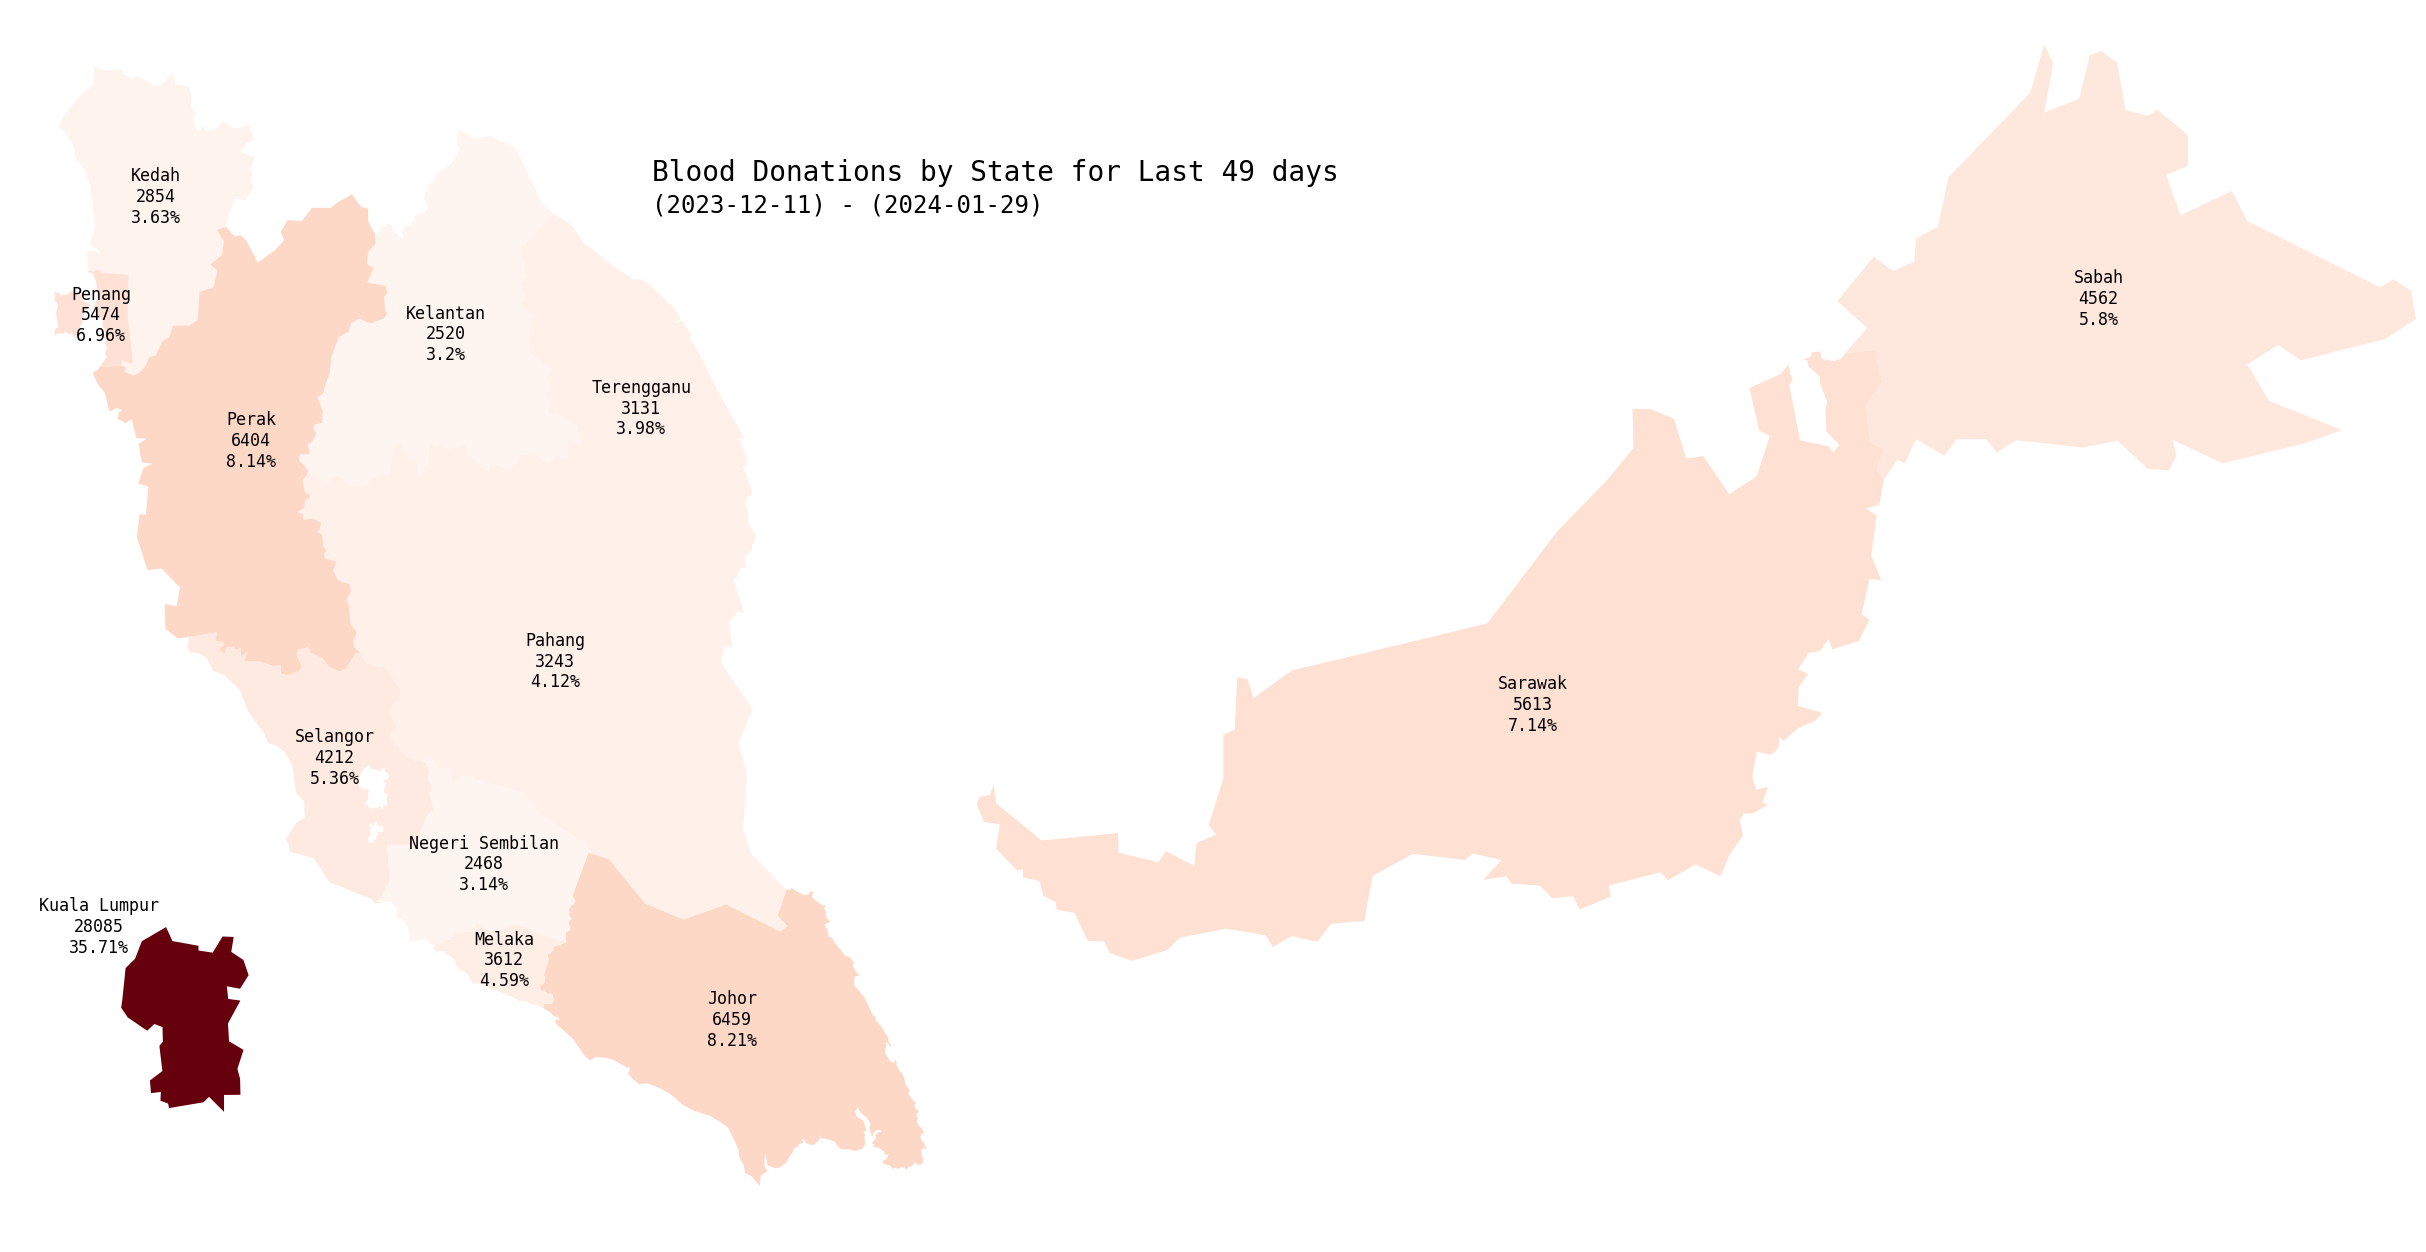

In [80]:
# Normalize Total Donation 
vmin, vmax = state49_df_merged['total_donation'].min(), state49_df_merged['total_donation'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
colour_gradient = 'Reds'

# Create the main plot for Peninsular Malaysia excluding Kuala Lumpur for clarity
fig, ax_main = plt.subplots(figsize=(16, 16))
plt.text(x=103,y=6,s = 'Blood Donations by State for Last 49 days',fontsize = 20)
plt.text(x=103,y=5.85,s = f'({last_49_days.date()}) - ({latest_date.date()})',fontsize = 'xx-large')
peninsular_without_kl = state49_df_merged[(state49_df_merged['state'] != 'Sabah') & (state49_df_merged['state'] != 'Sarawak') & (state49_df_merged['state'] != 'Kuala Lumpur')]
peninsular_without_kl.plot(column='total_donation', ax=ax_main, cmap=colour_gradient, norm=norm)

# Create an inset for Sabah and Sarawak
ax_sabah_sarawak = inset_axes(ax_main, width="150%", height="150%", loc='center left',
                               bbox_to_anchor=(1, 0.1, 1, 1), bbox_transform=ax_main.transAxes)
sabah_sarawak = state49_df_merged[(state49_df_merged['state'] == 'Sabah') | (state49_df_merged['state'] == 'Sarawak')]
sabah_sarawak.plot(column='total_donation', ax=ax_sabah_sarawak, cmap=colour_gradient,norm=norm)

# Adjust Sabah and Sarawak plot (optional zoom and removing axis)
ax_sabah_sarawak.set_xlim([sabah_sarawak.total_bounds[0], sabah_sarawak.total_bounds[2]])
ax_sabah_sarawak.set_ylim([sabah_sarawak.total_bounds[1], sabah_sarawak.total_bounds[3]])
ax_sabah_sarawak.set_frame_on(False)
ax_sabah_sarawak.set_xticks([])
ax_sabah_sarawak.set_yticks([])

# Create an inset for Kuala Lumpur
ax_kl = inset_axes(ax_main, width="15%", height="15%", loc='lower left',
                    bbox_to_anchor=(0.1, 0.1, 1, 1), bbox_transform=ax_main.transAxes)
kl = state49_df_merged[state49_df_merged['state'] == 'Kuala Lumpur']
kl.plot(column='total_donation', ax=ax_kl, cmap=colour_gradient,norm=norm)

# Adjust Kuala Lumpur plot (optional zoom and removing axis)
ax_kl.set_xlim([kl.total_bounds[0], kl.total_bounds[2]])
ax_kl.set_ylim([kl.total_bounds[1], kl.total_bounds[3]])
ax_kl.set_frame_on(False)
ax_kl.set_xticks([])
ax_kl.set_yticks([])

# Remove axis for the main plot for a cleaner look
ax_main.set_axis_off()

# Add Label to the plot
for idx, row in state49_df_merged.iterrows():
    
    # Get the position of the label
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    
    # Define the label text
    label_text = f"{row['state']}\n{row['total_donation']}\n{round(row['total_donation']/state49_df_merged['total_donation'].sum()*100,2)}%"
    # Place the label on the map
    if row['state'] == 'Kuala Lumpur':
        ax_kl.text(x-0.1, y+0.1, label_text, fontsize=12, ha='center', va='center',color='black')
    
    elif (row['state'] == 'Sarawak') | (row['state'] == 'Sabah'):
        ax_sabah_sarawak.text(x, y, label_text, fontsize=12, ha='center', va='center')
    
    else:
        ax_main.text(x, y, label_text, fontsize=12, ha='center', va='center')

# save chart as image
image_dir = r'./Output Image/'
image_name = 'choropleth.png'
plt.savefig(image_dir+image_name, bbox_inches='tight')


# Show the map
plt.show()


In [81]:
round(state49_df_merged['total_donation'][1]/state49_df_merged['total_donation'].sum()*100,2)

3.63

1. The data only shows blood donations but does not present the stocks of the blood itself
2. To compare more accurate on the state, we need to have the count of population for every state, to get the ratio of donor/no. of residence in the state. But I believe , they can transfer the blood packet to another hospital.

In [82]:
#now prepare data for Sankey
today_df = facility_df[facility_df['date']==latest_date][['hospital','state','blood_a','blood_b','blood_o','blood_ab']]
# Melt the data to transform blood type columns into rows
melted_data = today_df.melt(id_vars=['state', 'hospital'], value_vars=['blood_a', 'blood_b', 'blood_o', 'blood_ab'], 
                        var_name='blood_type', value_name='donations')

# Replace blood type column names with just the blood type
melted_data['blood_type'] = melted_data['blood_type'].str.replace('blood_', '')

# Creating a list of unique states, hospitals, and blood types to define nodes
states = list(melted_data['state'].unique())
hospitals = list(melted_data['hospital'].unique())
blood_types = list(melted_data['blood_type'].unique())
all_nodes = states + hospitals + blood_types

# # Create a mapping from node names to indices
node_indices = {node: idx for idx, node in enumerate(all_nodes)}
# Map the states, hospitals, and blood types to their respective indices
melted_data['source_state_to_hospital'] = melted_data['state'].map(node_indices)
melted_data['target_hospital_to_blood'] = melted_data['hospital'].map(node_indices)
melted_data['target_blood'] = melted_data['blood_type'].map(node_indices)

# Create two sets of links: one from state to hospital and another from hospital to blood type
links_state_to_hospital = melted_data[['source_state_to_hospital', 'target_hospital_to_blood', 'donations']]
links_hospital_to_blood = melted_data[['target_hospital_to_blood', 'target_blood', 'donations']]

# Combine the links into a single dataframe
links_combined = pd.concat([
    links_state_to_hospital.rename(columns={'source_state_to_hospital': 'source', 'target_hospital_to_blood': 'target'}),
    links_hospital_to_blood.rename(columns={'target_hospital_to_blood': 'source', 'target_blood': 'target'})
])

# Sum the donation counts for each link
links_summed = links_combined.groupby(['source', 'target']).sum().reset_index()

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 10,
      line = dict(color = "black", width = 0.5),
      label = all_nodes
    ),
    link = dict(
      source = links_summed['source'],
      target = links_summed['target'],
      value = links_summed['donations']
    ))])

fig.update_layout(title_text=f"State to Hospital to Blood Type Donations for the latest date ({latest_date.date()})", font_size=10)
fig.show()


Since Plotly's Sankey more on the interactive chart, it is not suitable for image output

C:\Users\adli\AppData\Local\Temp\ipykernel_36392\4022727328.py:9: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

C:\Users\adli\AppData\Local\Temp\ipykernel_36392\4022727328.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



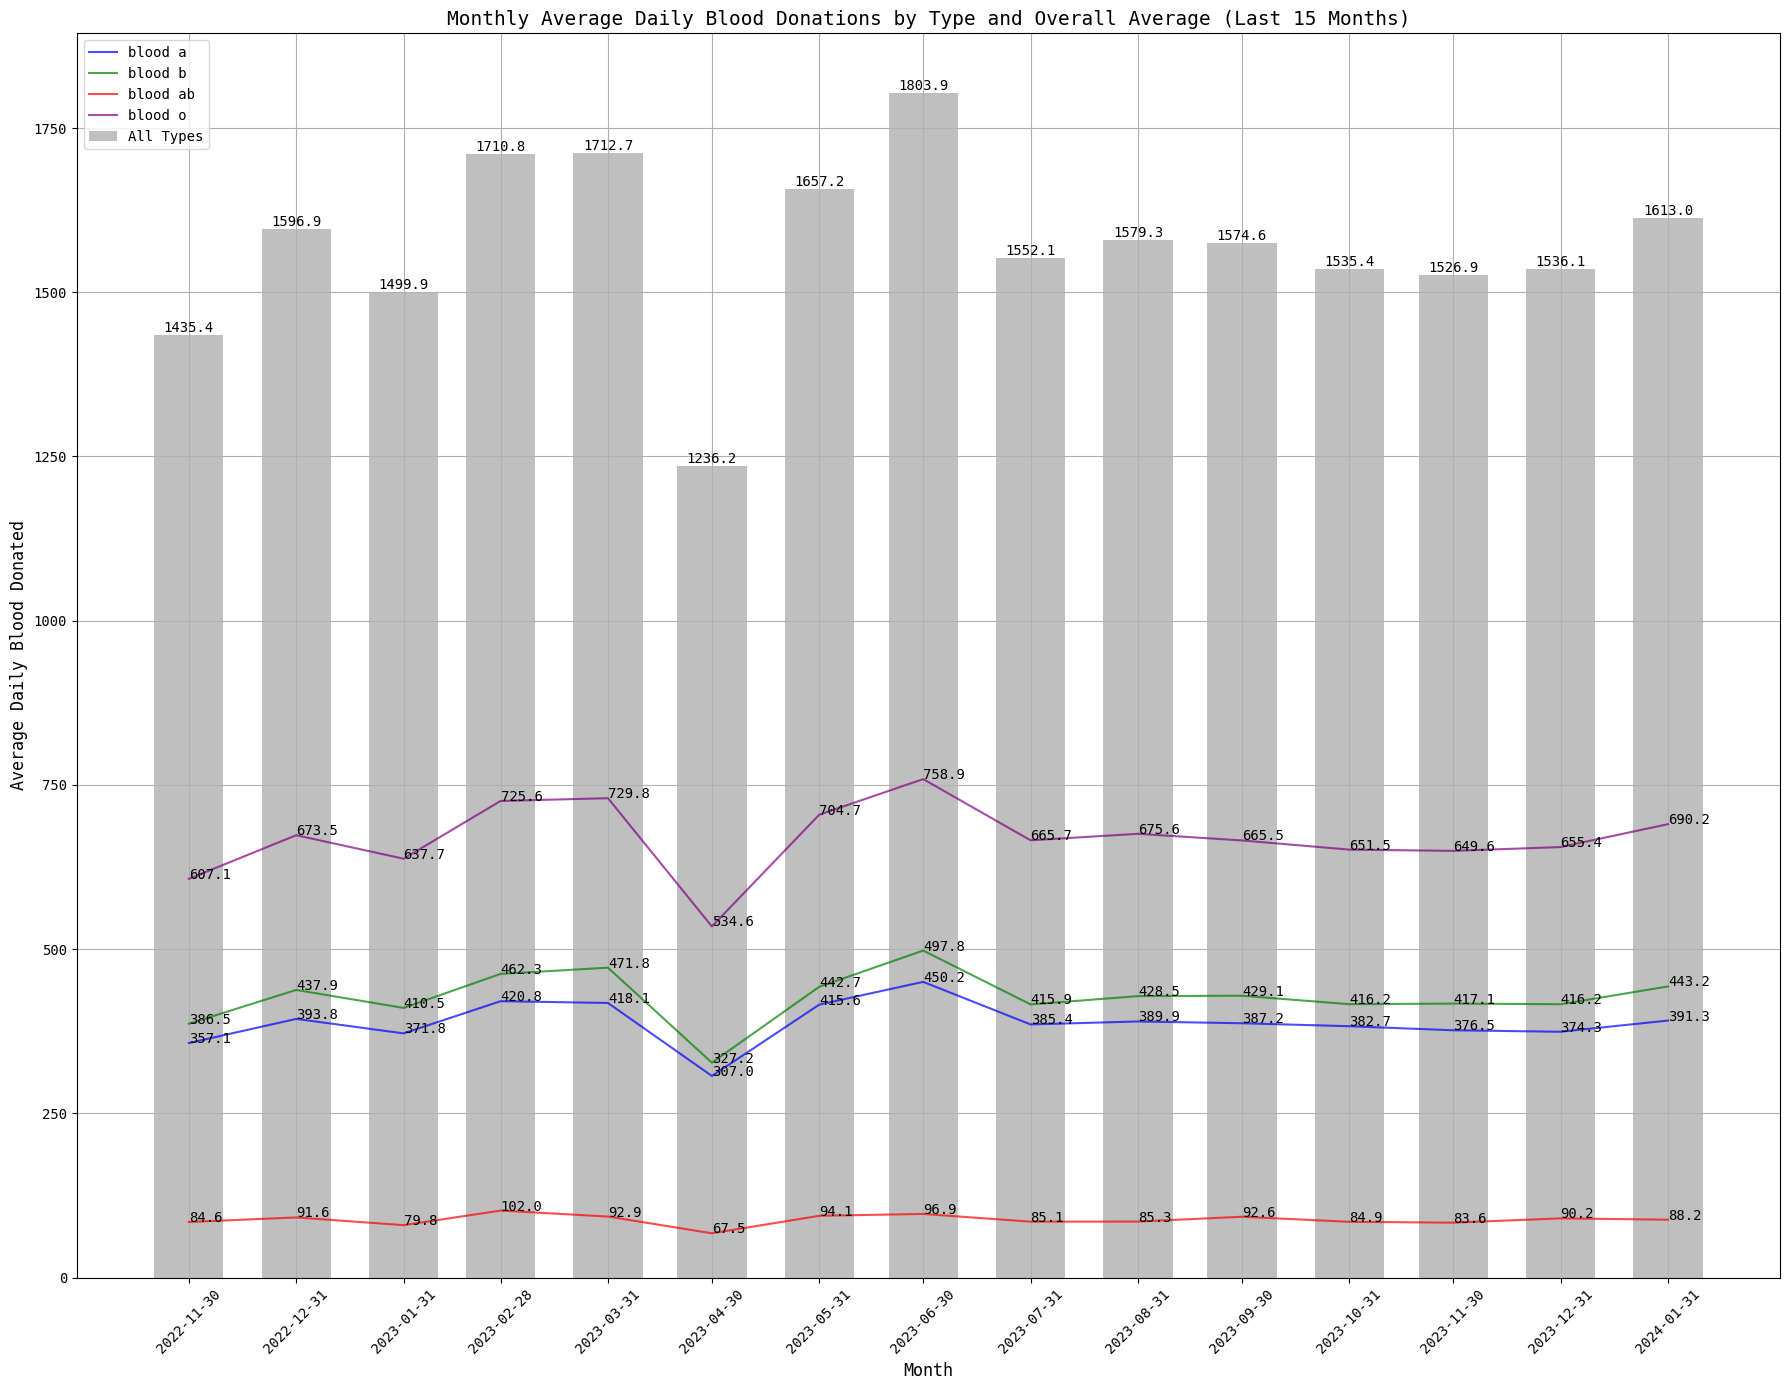

In [83]:
#Prepare to plot Time Series
# Grouping data by date
aggregated_data = facility_df.groupby('date')[['blood_a', 'blood_b', 'blood_ab', 'blood_o','daily']].sum()

# Resampling the data to a monthly frequency and calculating the average daily donations for each blood type
average_daily_per_month = aggregated_data.resample('ME').mean()

# Selecting the last 15 months for comparison
last_15_months_avg_daily = average_daily_per_month.last('15M')

# Setting the style for the plot
plt.rcParams.update({'font.family':'monospace'})

# Creating a larger figure
plt.figure(figsize=(18, 14))

# Time Series Plot for each blood type with data labels
for blood_type, color,blood_label in zip(['blood_a', 'blood_b', 'blood_ab', 'blood_o'], ['blue', 'green', 'red', 'purple'],['blood a', 'blood b', 'blood ab', 'blood o']):
    plt.plot(last_15_months_avg_daily.index, last_15_months_avg_daily[blood_type], label=blood_label, color=color, alpha=0.7)
    for x, y in zip(last_15_months_avg_daily.index, last_15_months_avg_daily[blood_type]):
        plt.text(x, y, f'{y:.1f}', color='black', fontsize=10)

# Bar Chart Overlay for average daily donation of all types with data labels
bar_width = 20  # days
bars = plt.bar(last_15_months_avg_daily.index, last_15_months_avg_daily['daily'], width=bar_width, label='All Types', color='grey', alpha=0.5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}', va='bottom', ha='center', fontsize=10)

plt.title('Monthly Average Daily Blood Donations by Type and Overall Average (Last 15 Months)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Daily Blood Donated', fontsize=12)
plt.xticks(last_15_months_avg_daily.index, rotation=45, fontsize=10)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
#Getting the average of delta with this month (latest date) and last month

<h1>Question 2</h1>
<p>Planning:</p>
<p>1. Two level Doughnut Chart Shows The Difference of Someone who Donate once and People Who Donate more than one time and group it to how many times had they donated</p>
<p>2. Horizontal Bar Chart to show the Distribution of Yesterday Donation by group of donation frequency

In [85]:
table = pq.read_table('data_granular\gran_data.parquet')
gran_df = table.to_pandas()

In [86]:
gran_df = pd.read_parquet('data_granular\gran_data.parquet')
gran_df

,donor_id,visit_date,birth_date
0,00000,2013-11-03,1964
1,00000,2014-05-26,1964
2,00000,2015-01-25,1964
3,00000,2015-08-09,1964
4,00000,2016-03-10,1964
...,...,...,...
6255911,056Vb,2024-01-29,1994
6255912,08KfK,2024-01-29,1991
6255913,04Keg,2024-01-29,1998
6255914,02Gt9,2024-01-29,1985


In [87]:
gran_df.head()

,donor_id,visit_date,birth_date
0,00000,2013-11-03,1964
1,00000,2014-05-26,1964
2,00000,2015-01-25,1964
3,00000,2015-08-09,1964
4,00000,2016-03-10,1964


In [88]:
#checking null in the dataset
gran_df.isna().sum()

donor_id      0
visit_date    0
birth_date    0
dtype: int64

Theres no null in the dataset

In [89]:
#Check the number of donator in the database
gran_df['donor_id'].nunique()

2247067

In [118]:
gran_df['visit_date'] = pd.to_datetime(gran_df['visit_date'])

AttributeError: module 'pandas' has no attribute 'to_date'

In [91]:
sort_gran = gran_df.sort_values(by=['donor_id','visit_date'])

In [92]:
sort_gran['donor_age'] = sort_gran['visit_date'].dt.year-sort_gran['birth_date']
sort_gran

,donor_id,visit_date,birth_date,donor_age
0,00000,2013-11-03,1964,49
1,00000,2014-05-26,1964,50
2,00000,2015-01-25,1964,51
3,00000,2015-08-09,1964,51
4,00000,2016-03-10,1964,52
...,...,...,...,...
6255592,09qyw,2024-01-29,1995,29
6255597,09qyx,2024-01-29,1992,32
6255598,09qyy,2024-01-29,1965,59
6255600,09qyz,2024-01-29,1993,31


From the age of the donor, we discovered there might be a data entry problem as there are donor who are more thn 100 years old donating the blood.
Thus we will make the rule to only take donor who are from 18 until 65 years old (the max age of eligible to become blood donors) cite from PPUM website.
https://www.ummc.edu.my/pesakit/blood-CRITERIA.asp?kodBM=#:~:text=Age%3A,donor%3A%2018%2D65%20years%20old

In [93]:
#filter the donor age less or equal to 65
sort_gran_fil = sort_gran[sort_gran['donor_age']<=65]
sort_gran_fil


,donor_id,visit_date,birth_date,donor_age
0,00000,2013-11-03,1964,49
1,00000,2014-05-26,1964,50
2,00000,2015-01-25,1964,51
3,00000,2015-08-09,1964,51
4,00000,2016-03-10,1964,52
...,...,...,...,...
6255592,09qyw,2024-01-29,1995,29
6255597,09qyx,2024-01-29,1992,32
6255598,09qyy,2024-01-29,1965,59
6255600,09qyz,2024-01-29,1993,31


To show does Malaysia Retain their blood donater, by looking at the frequency of repeated number of donation.
We generalize all type of donation into blood donation

In [94]:
#group by donor id to get the number of their donations
donor_donations = sort_gran_fil.groupby('donor_id').size().reset_index(name='donation_count')
donor_donations

,donor_id,donation_count
0,00000,11
1,00001,4
2,00002,12
3,00003,5
4,00004,3
...,...,...
2246667,09qyw,1
2246668,09qyx,1
2246669,09qyy,1
2246670,09qyz,1


<Axes: ylabel='Frequency'>

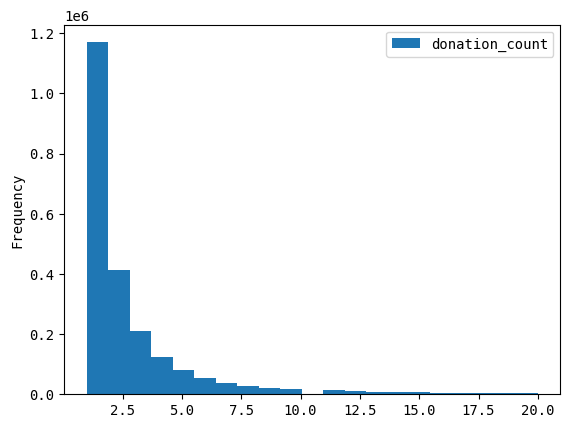

In [95]:
#Plot Histogram for the donation count to see the distribution
donor_donations[donor_donations['donation_count']<=20].plot(kind='hist', bins=21)

Since using histogram does not give much insights except there are a lot of people who come one time to donate blood. Lets try using Pie Chart for two category one time donor and a repeater

In [96]:
count_bins = [1, 2, 4, 7, float('inf')]
count_labels = ['New Donor','2-3 Donations','4-7 Donations','8+ Donations']
donor_donations['donation_count_group'] = pd.cut(donor_donations['donation_count'],bins=count_bins,labels=count_labels,right=False)
donor_donations

,donor_id,donation_count,donation_count_group
0,00000,11,8+ Donations
1,00001,4,4-7 Donations
2,00002,12,8+ Donations
3,00003,5,4-7 Donations
4,00004,3,2-3 Donations
...,...,...,...
2246667,09qyw,1,New Donor
2246668,09qyx,1,New Donor
2246669,09qyy,1,New Donor
2246670,09qyz,1,New Donor


([<matplotlib.patches.Wedge at 0x181003b0850>,
 [Text(0.21312434811313127, 3.2931106893393904, 'Repeater'),
  Text(-0.21312434811313094, -3.2931106893393904, 'One Time')],
 [Text(0.1162496444253443, 1.7962421941851219, '47.94%'),
  Text(-0.11624964442534413, -1.7962421941851219, '52.06%')])

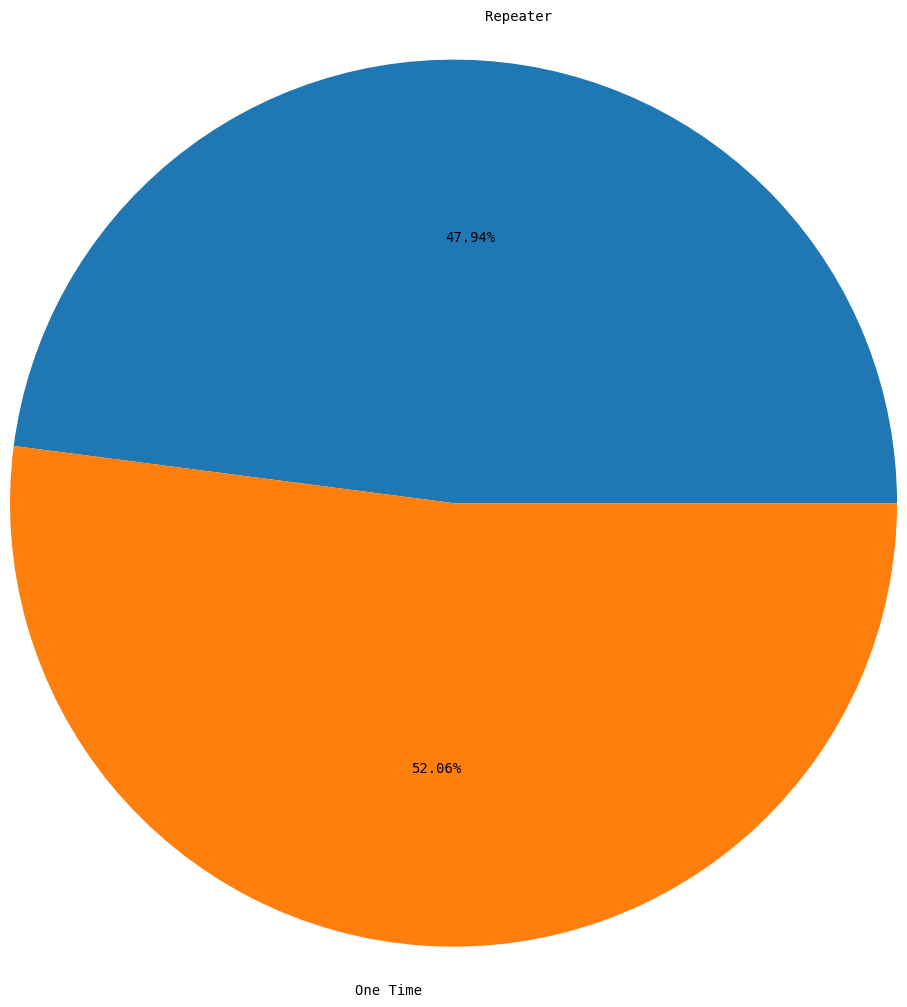

In [97]:
#Plot PieChart for repeater or not
one_time_count = donor_donations[donor_donations['donation_count_group']=='New Donor']['donation_count_group'].count()
repeater_count = donor_donations[donor_donations['donation_count_group']!='New Donor']['donation_count_group'].count()

fig,ax= plt.subplots()
label = ['Repeater','One Time']
sizes = [repeater_count,one_time_count]
ax.pie(sizes,labels=label,autopct='%1.2f%%',radius=3)


In [98]:
#Banding the donation_count
first_group = donor_donations[donor_donations['donation_count_group']=='2-3 Donations']['donor_id'].count()
second_group = donor_donations[donor_donations['donation_count_group']=='4-7 Donations']['donor_id'].count()
third_group = donor_donations[donor_donations['donation_count_group']=='8+ Donations']['donor_id'].count()

([<matplotlib.patches.Wedge at 0x1810051c9d0>,
 [Text(2.1165102174114714, 2.5318737131999396, '2-3'),
  Text(-1.7015401403022594, 2.827500866655954, '4-7'),
  Text(-3.0428103749678583, 1.2772255172787466, '8+'),
  Text(-0.21312434811313094, -3.2931106893393904, '1')],
 [Text(1.154460118588075, 1.3810220253817849, '27.84%'),
  Text(-0.9281128038012322, 1.5422731999941564, '11.57%'),
  Text(-1.659714749982468, 0.6966684639702252, '8.54%'),
  Text(-0.11624964442534413, -1.7962421941851219, '52.06%')])

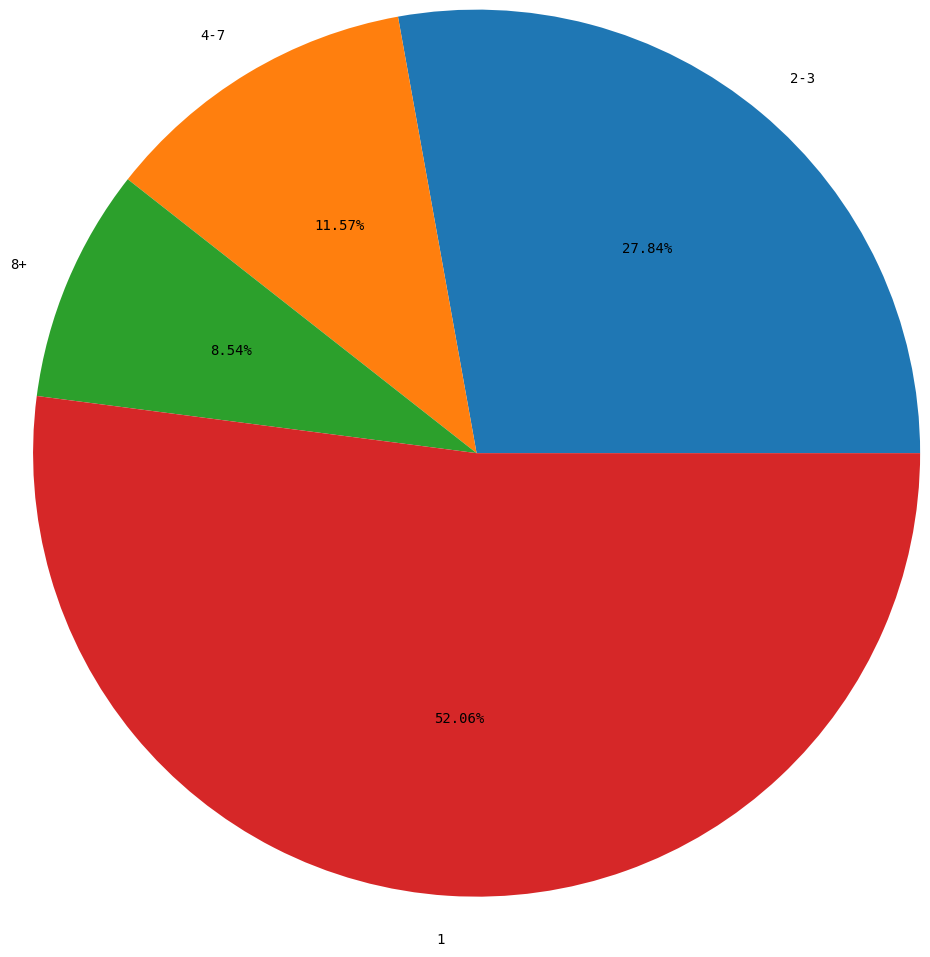

In [99]:
#Pie Chart for the group of Repeater
fig,ax= plt.subplots()
label = ['2-3','4-7','8+','1']
sizes = [first_group,second_group,third_group,one_time_count]
ax.pie(sizes,labels=label,autopct='%1.2f%%',radius=3)

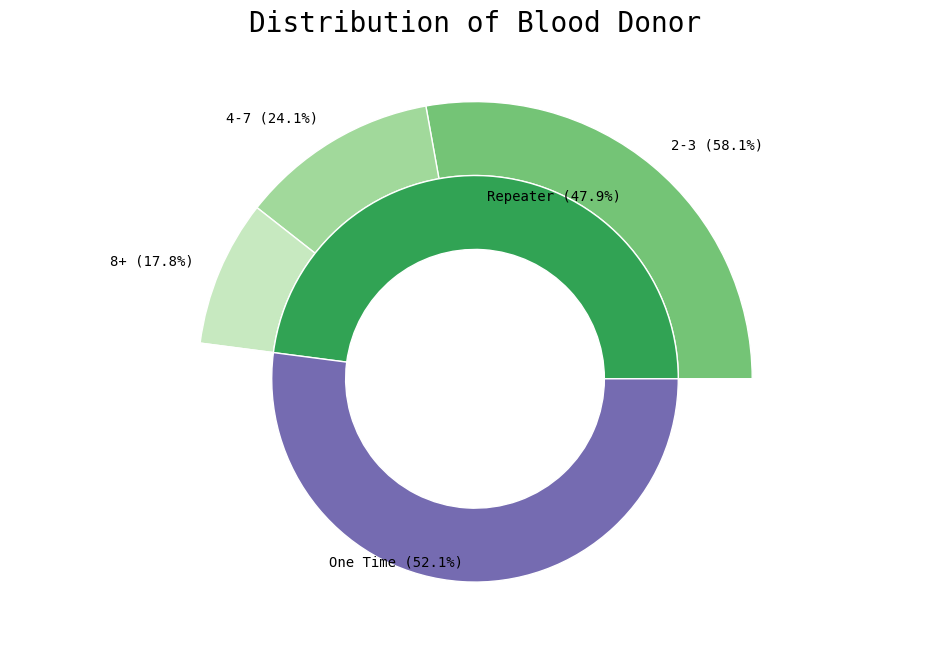

In [100]:
#Plot a two level Pie Chart
fig,ax = plt.subplots(figsize=(12,3))
ax.axis('equal')
width = 0.8

plt.text(0, 4, 'Distribution of Blood Donor', horizontalalignment='center', verticalalignment='top', fontsize=20,)

#label and size for outer donut chart
sizes_out = [first_group,second_group,third_group,one_time_count]
label_out = ['2-3','4-7','8+','1']

#label and size for inner donut chart
label_in = ['Repeater','One Time']
sizes_in = [repeater_count,one_time_count]

# Calculate the percentages for the outer ring
percentages_out = [f"{(size / sum(sizes_out[0:3]) * 100):.1f}%" for size in sizes_out]

# Update labels for the outer ring with percentages
label_out_with_perc = [f"{label} ({perc})" for label, perc in zip(label_out, percentages_out)]
label_out_with_perc[3] = '' #To make the 1 time donor invisible

# Calculate the percentages for the inner ring
percentages_in = [f"{(size / sum(sizes_in) * 100):.1f}%" for size in sizes_in]

# Update labels for the inner ring with percentages
label_in_with_perc = [f"{label} ({perc})" for label, perc in zip(label_in, percentages_in)]


#Outer Ring (Donation Count Band)
cm = plt.get_cmap("tab20c")

cout = cm(np.array([9,10,11,13]))
cout[3] = mcolors.to_rgba('white')  # Convert 'white' to RGBA
pie, *_ = ax.pie(sizes_out, radius=3, labels=label_out_with_perc, colors=cout)
plt.setp(pie, width=width, edgecolor='white',)

#Inner Ring (Repeater Or Not)
cin = cm(np.array([8,12]))
pie2, *_= ax.pie(sizes_in, radius=3-width, labels=label_in_with_perc,
                 labeldistance=0.9, colors=cin,rotatelabels=0)
plt.setp(pie2, width=width, edgecolor='white')

image_name = 'doughnut.png'
plt.savefig(image_dir+image_name, bbox_inches='tight')

This is a good for a summary report but its not suitable for daily report. I will add for daily data.

In [101]:
#Getting all latest date donor
latest_date = max(sort_gran_fil['visit_date'])
latest_donor = sort_gran_fil[sort_gran_fil['visit_date']==latest_date]


In [124]:
latest_date.strftime(r'%d-%m-%Y')

'29-01-2024'

In [127]:
datetime.datetime.today().strftime(r'%H:%M')

'16:37'

In [102]:
# Merge the two dataframes on 'donor_id'
latest_donor = latest_donor.merge(donor_donations[['donor_id', 'donation_count']], on='donor_id', how='left')

# Rename the 'donation_count' column to 'donations_count'
latest_donor.rename(columns={'donation_count': 'donations_count'}, inplace=True)

# Display the first 10 rows of the updated dataframe
latest_donor.head(10)


,donor_id,visit_date,birth_date,donor_age,donations_count
0,000qG,2024-01-29,1976,48,6
1,000sZ,2024-01-29,1989,35,13
2,001lY,2024-01-29,1982,42,23
3,002Pt,2024-01-29,1998,26,2
4,002jB,2024-01-29,1987,37,3
5,004P5,2024-01-29,1964,60,14
6,004nn,2024-01-29,1991,33,23
7,004z6,2024-01-29,1963,61,13
8,006F9,2024-01-29,2001,23,2
9,006aV,2024-01-29,1992,32,3


In [103]:
latest_donor[latest_donor['donations_count']== 1]['donations_count'].count()

174

In [104]:
count_bins = [1, 2, 4, 7, float('inf')]
count_labels = ['New Donor','2-3 Donations','4-7 Donations','8+ Donations']
latest_donor['donations_count_group'] = pd.cut(latest_donor['donations_count'],
                                                bins=count_bins,
                                                labels=count_labels,
                                                right=False)



In [105]:
#Banding the age to Age Group with the newdonors csv file as reference
age_bins = [17, 24, 29, 34, 39, 44, 49, 54, 59, 65]
age_labels = ['17-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-65']
latest_donor['donor_age_group'] = pd.cut(latest_donor['donor_age'],bins=age_bins,labels=age_labels)


In [106]:
latest_donor

,donor_id,visit_date,birth_date,donor_age,donations_count,donations_count_group,donor_age_group
0,000qG,2024-01-29,1976,48,6,4-7 Donations,45-49
1,000sZ,2024-01-29,1989,35,13,8+ Donations,35-39
2,001lY,2024-01-29,1982,42,23,8+ Donations,40-44
3,002Pt,2024-01-29,1998,26,2,2-3 Donations,25-29
4,002jB,2024-01-29,1987,37,3,2-3 Donations,35-39
...,...,...,...,...,...,...,...
972,09qyw,2024-01-29,1995,29,1,New Donor,25-29
973,09qyx,2024-01-29,1992,32,1,New Donor,30-34
974,09qyy,2024-01-29,1965,59,1,New Donor,55-59
975,09qyz,2024-01-29,1993,31,1,New Donor,30-34


In [107]:
grouped_data = latest_donor.groupby([ 'donor_age_group','donations_count_group']).size().unstack(fill_value=0)
grouped_data

C:\Users\adli\AppData\Local\Temp\ipykernel_36392\2315077890.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



donations_count_group,New Donor,2-3 Donations,4-7 Donations,8+ Donations
donor_age_group,,,,
17-24,39,34,21,5
25-29,28,36,28,32
30-34,36,40,35,63
35-39,31,31,38,82
40-44,18,26,28,66
45-49,12,21,21,74
50-54,4,12,13,43
55-59,5,6,4,31
60-65,1,1,0,12


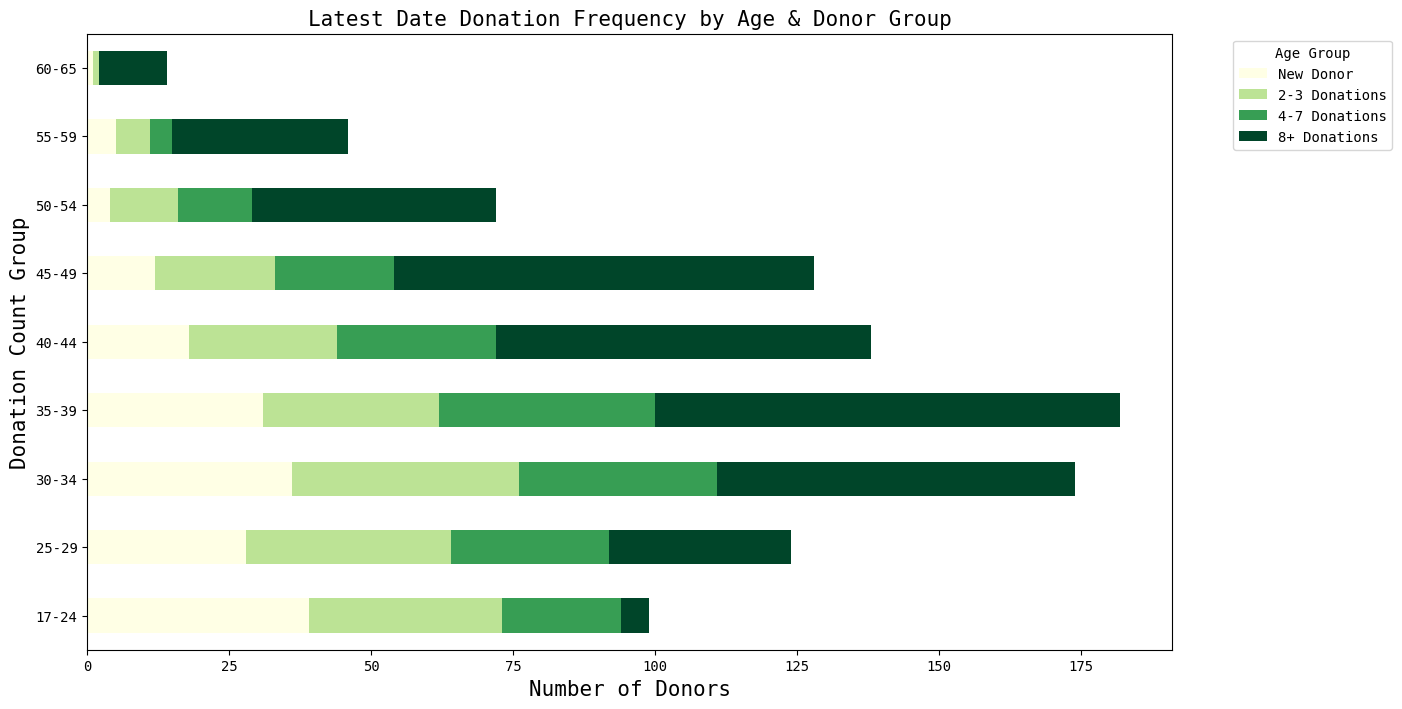

In [108]:
# Plot the stacked horizontal bar chart
grouped_data.plot(kind='barh', stacked=True, figsize=(14, 8),cmap='YlGn')

# Adding titles and labels
plt.title('Latest Date Donation Frequency by Age & Donor Group', fontsize=15)
plt.xlabel('Number of Donors', fontsize=15)
plt.ylabel('Donation Count Group', fontsize=15)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
# Show the plot
plt.show()